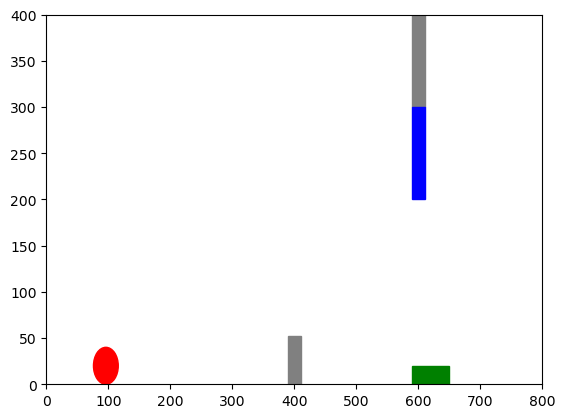

In [8]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Constants
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 400
BAR_WIDTH = 20
BAR_HEIGHT = 100
BALL_RADIUS = 20
BASKET_WIDTH = 60
BASKET_HEIGHT = 20
MOVEMENT_SPEED = 5
VELOCITY = 10

class BallSortCraneEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(BallSortCraneEnv, self).__init__()
        # Define action and observation space
        self.action_space = spaces.Discrete(5)
        self.observation_space = spaces.Box(low=0, high=max(SCREEN_WIDTH, SCREEN_HEIGHT), shape=(6,), dtype=np.float32)

        # Initialize game variables
        self.bar_x = SCREEN_WIDTH - (SCREEN_WIDTH // 4)
        self.bar_y = SCREEN_HEIGHT - (SCREEN_HEIGHT // 4)
        self.bar_height = BAR_HEIGHT
        self.extend_bar = False
        self.shrink_bar = False
        self.move_left = False
        self.move_right = False
        self.score = 0
        self.is_grabbing = False
        self.previous_distance_to_ball = float('inf')
        self.previous_distance_to_basket = float('inf')
        self.ball_x, self.ball_y, self.basket_x, self.basket_y, self.pillar_height = self.randomize_positions()
        self.figure, self.ax = plt.subplots()
        self.current_step = 0
        
    def randomize_positions(self):
        ball_x = random.randint(BALL_RADIUS, SCREEN_WIDTH // 2 - BALL_RADIUS)
        basket_x = random.randint(SCREEN_WIDTH // 2 + BASKET_WIDTH // 2, SCREEN_WIDTH - BASKET_WIDTH // 2)
        max_pillar_height = SCREEN_HEIGHT // 2
        pillar_height = random.randint(50, max_pillar_height)
        ball_y = BALL_RADIUS
        basket_y = BASKET_HEIGHT // 2
        return ball_x, ball_y, basket_x, basket_y, pillar_height

    def step(self, action):

        if action == 0:  # Move Left
            self.move_left = True
            self.move_right = False
        elif action == 1:  # Move Right
            self.move_left = False
            self.move_right = True
        elif action == 2:  # Extend Bar
            self.extend_bar = True
            self.shrink_bar = False
        elif action == 3:  # Shrink Bar
            self.extend_bar = False
            self.shrink_bar = True
        elif action == 4:  # Grab/Release
            self.is_grabbing = not self.is_grabbing
        self.current_step += 1
        self.update_game_state()

        reward = self.calculate_reward()
        done = self.is_game_done()
        obs = np.array([self.ball_x, self.ball_y, self.bar_x, self.bar_y, self.basket_x, self.basket_y], dtype=np.float32)

        return obs, reward, done, {}

    def reset(self):
        self.current_step = 0
        self.bar_x, self.bar_y, self.bar_height = SCREEN_WIDTH - (SCREEN_WIDTH // 4), SCREEN_HEIGHT - (SCREEN_HEIGHT // 4), BAR_HEIGHT
        self.extend_bar, self.shrink_bar, self.move_left, self.move_right, self.is_grabbing = False, False, False, False, False
        self.score = 0
        self.previous_distance_to_ball = float('inf')
        self.previous_distance_to_basket = float('inf')
        self.ball_x, self.ball_y, self.basket_x, self.basket_y, self.pillar_height = self.randomize_positions()
        return np.array([self.ball_x, self.ball_y, self.bar_x, self.bar_y, self.basket_x, self.basket_y], dtype=np.float32)

    def render(self, mode='human'):
        
        self.ax.clear()
        self.ax.set_xlim(0, SCREEN_WIDTH)
        self.ax.set_ylim(0, SCREEN_HEIGHT)

        # Draw the pillar in the middle of the screen
        pillar_x = SCREEN_WIDTH // 2
        pillar = patches.Rectangle((pillar_x - 10, 0), 20, self.pillar_height, color='gray')
        self.ax.add_patch(pillar)

        # Draw the crane's arm and bar
        crane_base_x = self.bar_x
        crane_base_y = SCREEN_HEIGHT
        crane_arm_length = SCREEN_HEIGHT - self.bar_y + self.bar_height
        crane_arm = patches.Rectangle((crane_base_x - BAR_WIDTH/2, self.bar_y), BAR_WIDTH, crane_arm_length, color='gray')
        self.ax.add_patch(crane_arm)
        bar = patches.Rectangle((self.bar_x - BAR_WIDTH/2, self.bar_y - self.bar_height), BAR_WIDTH, self.bar_height, color='blue')
        self.ax.add_patch(bar)

        # Draw the ball
        ball = patches.Circle((self.ball_x, self.ball_y), BALL_RADIUS, color='red')
        self.ax.add_patch(ball)

        # Draw the basket
        basket = patches.Rectangle((self.basket_x - BASKET_WIDTH/2, self.basket_y - BASKET_HEIGHT/2), BASKET_WIDTH, BASKET_HEIGHT, color='green')
        self.ax.add_patch(basket)
        
        if mode == 'rgb_array':
            # Convert the plot to an RGB array
            self.figure.canvas.draw()
            width, height = self.figure.get_size_inches() * self.figure.get_dpi()
            image = np.frombuffer(self.figure.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(int(height), int(width), 3)
            return image
        elif mode == 'human':
            # [Existing code for human rendering]
            plt.draw()
            plt.pause(0.01)

    def close(self):
        plt.close(self.figure)

    def update_game_state(self):
        # Update bar position
        if self.move_left:
            self.bar_x = max(self.bar_x - MOVEMENT_SPEED, BAR_WIDTH / 2)
        if self.move_right:
            self.bar_x = min(self.bar_x + MOVEMENT_SPEED, SCREEN_WIDTH - BAR_WIDTH / 2)

        # Update bar height
        if self.extend_bar and self.bar_height < SCREEN_HEIGHT - self.bar_y:
            self.bar_height += 10
        if self.shrink_bar and self.bar_height > 10:
            self.bar_height -= 10

        # Handle ball grabbing logic
        if self.is_grabbing:
            # Check if the bar is above the ball
            if self.bar_x - BAR_WIDTH / 2 < self.ball_x < self.bar_x + BAR_WIDTH / 2 and \
               self.ball_y < self.bar_y - self.bar_height + BALL_RADIUS:
                self.ball_x = self.bar_x
                self.ball_y = self.bar_y - self.bar_height + BALL_RADIUS
        else:
            # Ball falls due to gravity
            if self.ball_y > BALL_RADIUS:
                self.ball_y -= VELOCITY
            else:
                self.ball_y = BALL_RADIUS  # Ensure ball doesn't go below the ground


    def calculate_reward(self):
        reward = 0
        distance_to_ball = abs(self.ball_x - self.bar_x)
        distance_to_basket = abs(self.basket_x - self.bar_x)

        # Reward for grabbing the ball
        if self.is_grabbing and self.ball_y < self.bar_y - self.bar_height + BALL_RADIUS:
            reward += 1

        # Penalty for releasing the ball outside the basket
        if not self.is_grabbing and self.ball_y < BALL_RADIUS:
            if not (self.ball_x + BALL_RADIUS > self.basket_x - BASKET_WIDTH / 2 and 
                    self.ball_x - BALL_RADIUS < self.basket_x + BASKET_WIDTH / 2):
                reward -= 1

        # Reward for moving towards the ball when not holding it
        if not self.is_grabbing and self.previous_distance_to_ball > distance_to_ball:
            reward += 0.1

        # Reward for moving towards the basket when holding the ball
        if self.is_grabbing and self.previous_distance_to_basket > distance_to_basket:
            reward += 0.1

        # Update previous distances
        self.previous_distance_to_ball = distance_to_ball
        self.previous_distance_to_basket = distance_to_basket

        return reward

    def is_game_done(self):
        max_score = 10
        max_steps = 1000
        return self.score >= max_score or self.current_step >= max_steps


# Create and test your environment
env = BallSortCraneEnv()
env.reset()
env.render()

Step: 0, Action: 4, Reward: 1.1, Total Reward: 1.1
Step: 1, Action: 0, Reward: 1, Total Reward: 2.1
Step: 2, Action: 3, Reward: 1, Total Reward: 3.1
Step: 3, Action: 1, Reward: 1.1, Total Reward: 4.2
Step: 4, Action: 3, Reward: 1.1, Total Reward: 5.300000000000001
Step: 5, Action: 3, Reward: 1.1, Total Reward: 6.4
Step: 6, Action: 3, Reward: 1.1, Total Reward: 7.5
Step: 7, Action: 2, Reward: 1.1, Total Reward: 8.6
Step: 8, Action: 0, Reward: 1, Total Reward: 9.6
Step: 9, Action: 0, Reward: 1, Total Reward: 10.6
Step: 10, Action: 2, Reward: 1, Total Reward: 11.6
Step: 11, Action: 2, Reward: 1, Total Reward: 12.6
Step: 12, Action: 2, Reward: 1, Total Reward: 13.6
Step: 13, Action: 1, Reward: 1.1, Total Reward: 14.7
Step: 14, Action: 4, Reward: 0, Total Reward: 14.7
Step: 15, Action: 0, Reward: 0.1, Total Reward: 14.799999999999999
Step: 16, Action: 1, Reward: 0, Total Reward: 14.799999999999999
Step: 17, Action: 0, Reward: 0.1, Total Reward: 14.899999999999999
Step: 18, Action: 3, Reward

1/1 [==============================] - 0s 15ms/step
Step: 37, Action: 1, Reward: 0, Total Reward: 20.1
1/1 [==============================] - 0s 17ms/step
Step: 38, Action: 4, Reward: 1.1, Total Reward: 21.200000000000003
1/1 [==============================] - 0s 15ms/step
Step: 39, Action: 4, Reward: 0, Total Reward: 21.200000000000003
1/1 [==============================] - 0s 16ms/step
Step: 40, Action: 0, Reward: 0.1, Total Reward: 21.300000000000004
1/1 [==============================] - 0s 21ms/step
Step: 41, Action: 2, Reward: 0.1, Total Reward: 21.400000000000006
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
Step: 42, Action: 1, Reward: 0, Total Reward: 21.400000000000006
1/1 [==============================] - 0s 14ms/step
Step: 43, Action: 2, Reward: 0, Total Reward: 21.400000000000006
1/1 [==============================] - 0s 16ms/step
Step: 44, Action: 2, Reward: 0, Total Reward: 21.400000000000006
1/1 [==============================] - 0s 16ms/step
Step: 45, Action: 0, Reward: 0.1, Total Reward: 21.500000000000007
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Step: 46, Action: 0, Reward: 0.1, Total Reward: 21.60000000000001
1/1 [==============================] - 0s 14ms/step
Step: 47, Action: 0, Reward: 0.1, Total Reward: 21.70000000000001
1/1 [==============================] - 0s 15ms/step
Step: 48, Action: 3, Reward: 0.1, Total Reward: 21.80000000000001
1/1 [==============================] - 0s 15ms/step
Step: 49, Action: 4, Reward: 1, Total Reward: 22.80000000000001
1/1 [==============================] - 0s 18ms/step
Episode: 0, Average Loss: 1222.6450, Total Reward: 22.80000000000001, Epsilon: 1.00


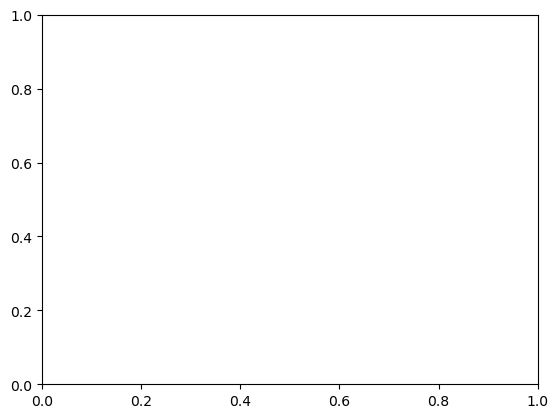

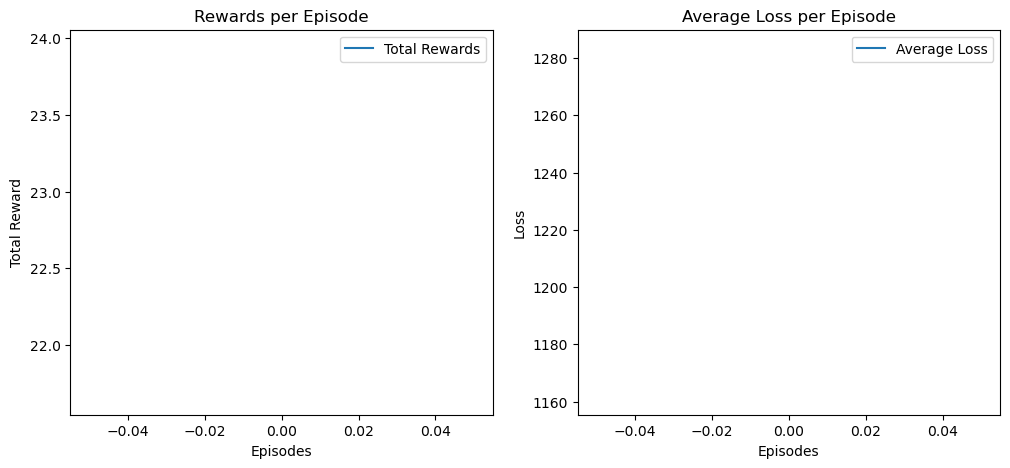

Step: 0, Action: 3, Reward: 0.1, Total Reward: 0.1
1/1 [==============================] - 0s 14ms/step
Step: 1, Action: 4, Reward: 1, Total Reward: 1.1
1/1 [==============================] - 0s 14ms/step
Step: 2, Action: 4, Reward: 0, Total Reward: 1.1
1/1 [==============================] - 0s 17ms/step
Step: 3, Action: 3, Reward: 0, Total Reward: 1.1
1/1 [==============================] - 0s 15ms/step
Step: 4, Action: 0, Reward: 0.1, Total Reward: 1.2000000000000002
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Step: 5, Action: 0, Reward: 0.1, Total Reward: 1.3000000000000003
1/1 [==============================] - 0s 15ms/step
Step: 6, Action: 3, Reward: 0.1, Total Reward: 1.4000000000000004
1/1 [==============================] - 0s 18ms/step
Step: 7, Action: 1, Reward: 0, Total Reward: 1.4000000000000004
1/1 [==============================] - 0s 15ms/step
Step: 8, Action: 2, Reward: 0, Total Reward: 1.4000000000000004
1/1 [==============================] - 0s 16ms/step
Step: 9, Action: 1, Reward: 0, Total Reward: 1.4000000000000004
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Step: 10, Action: 3, Reward: 0, Total Reward: 1.4000000000000004
1/1 [==============================] - 0s 16ms/step
Step: 11, Action: 3, Reward: 0, Total Reward: 1.4000000000000004
1/1 [==============================] - 0s 14ms/step
Step: 12, Action: 2, Reward: 0, Total Reward: 1.4000000000000004
1/1 [==============================] - 0s 16ms/step
Step: 13, Action: 1, Reward: 0, Total Reward: 1.4000000000000004
1/1 [==============================] - 0s 16ms/step
Step: 14, Action: 4, Reward: 1.1, Total Reward: 2.5000000000000004
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step
Step: 15, Action: 2, Reward: 1.1, Total Reward: 3.6000000000000005
1/1 [==============================] - 0s 15ms/step
Step: 16, Action: 2, Reward: 1.1, Total Reward: 4.700000000000001
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 14ms/step
Step: 17, Action: 4, Reward: 0, Total Reward: 4.700000000000001
1/1 [==============================] - 0s 18ms/step
Step: 18, Action: 0, Reward: 0.1, Total Reward: 4.800000000000001
1/1 [==============================] - 0s 15ms/step
Step: 19, Action: 4, Reward: 1, Total Reward: 5.800000000000001
1/1 [==============================] - 0s 14ms/step
Step: 20, Action: 1, Reward: 1.1, Total Reward: 6.9
1/1 [==============================] - 0s 15ms/step
Step: 21, Action: 3, Reward: 1.1, Total Reward: 8.0
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
Step: 22, Action: 4, Reward: 0, Total Reward: 8.0
1/1 [==============================] - 0s 16ms/step
Step: 23, Action: 3, Reward: 0, Total Reward: 8.0
1/1 [==============================] - 0s 16ms/step
Step: 24, Action: 2, Reward: 0, Total Reward: 8.0
1/1 [==============================] - 0s 15ms/step
Step: 25, Action: 3, Reward: 0, Total Reward: 8.0
1/1 [==============================] - 0s 15ms/step
Step: 26, Action: 2, Reward: 0, Total Reward: 8.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Step: 27, Action: 1, Reward: 0, Total Reward: 8.0
1/1 [==============================] - 0s 17ms/step
Step: 28, Action: 3, Reward: 0, Total Reward: 8.0
1/1 [==============================] - 0s 15ms/step
Step: 29, Action: 4, Reward: 1.1, Total Reward: 9.1
1/1 [==============================] - 0s 16ms/step
Step: 30, Action: 3, Reward: 1.1, Total Reward: 10.2
1/1 [==============================] - 0s 15ms/step
Step: 31, Action: 3, Reward: 1.1, Total Reward: 11.299999999999999
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
Step: 32, Action: 0, Reward: 1, Total Reward: 12.299999999999999
1/1 [==============================] - 0s 14ms/step
Step: 33, Action: 4, Reward: 0.1, Total Reward: 12.399999999999999
1/1 [==============================] - 0s 16ms/step
Step: 34, Action: 4, Reward: 1, Total Reward: 13.399999999999999
1/1 [==============================] - 0s 14ms/step
Step: 35, Action: 4, Reward: 0.1, Total Reward: 13.499999999999998
1/1 [==============================] - 0s 16ms/step
Step: 36, Action: 1, Reward: 0, Total Reward: 13.499999999999998
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Step: 37, Action: 3, Reward: 0, Total Reward: 13.499999999999998
1/1 [==============================] - 0s 14ms/step
Step: 38, Action: 2, Reward: 0, Total Reward: 13.499999999999998
1/1 [==============================] - 0s 15ms/step
Step: 39, Action: 1, Reward: 0, Total Reward: 13.499999999999998
1/1 [==============================] - 0s 15ms/step
Step: 40, Action: 2, Reward: 0, Total Reward: 13.499999999999998
1/1 [==============================] - 0s 14ms/step
Step: 41, Action: 1, Reward: 0, Total Reward: 13.499999999999998


1/1 [==============================] - 0s 21ms/step
Step: 42, Action: 1, Reward: 0, Total Reward: 13.499999999999998
1/1 [==============================] - 0s 15ms/step
Step: 43, Action: 0, Reward: 0.1, Total Reward: 13.599999999999998
1/1 [==============================] - 0s 17ms/step
Step: 44, Action: 0, Reward: 0.1, Total Reward: 13.699999999999998
1/1 [==============================] - 0s 14ms/step
Step: 45, Action: 3, Reward: 0.1, Total Reward: 13.799999999999997
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
Step: 46, Action: 3, Reward: 0.1, Total Reward: 13.899999999999997
1/1 [==============================] - 0s 15ms/step
Step: 47, Action: 2, Reward: 0.1, Total Reward: 13.999999999999996
1/1 [==============================] - 0s 14ms/step
Step: 48, Action: 3, Reward: 0.1, Total Reward: 14.099999999999996
1/1 [==============================] - 0s 15ms/step
Step: 49, Action: 0, Reward: 0.1, Total Reward: 14.199999999999996
1/1 [==============================] - 0s 21ms/step
Episode: 1, Average Loss: 1.4707, Total Reward: 14.199999999999996, Epsilon: 1.00
Step: 0, Action: 0, Reward: 0.1, Total Reward: 0.1
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
Step: 1, Action: 4, Reward: 1, Total Reward: 1.1
1/1 [==============================] - 0s 17ms/step
Step: 2, Action: 0, Reward: 1, Total Reward: 2.1
1/1 [==============================] - 0s 17ms/step
Step: 3, Action: 2, Reward: 1, Total Reward: 3.1
1/1 [==============================] - 0s 14ms/step
Step: 4, Action: 0, Reward: 1, Total Reward: 4.1
1/1 [==============================] - 0s 15ms/step
Step: 5, Action: 3, Reward: 1, Total Reward: 5.1
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step
Step: 6, Action: 0, Reward: 1, Total Reward: 6.1
1/1 [==============================] - 0s 17ms/step
Step: 7, Action: 0, Reward: 1, Total Reward: 7.1
1/1 [==============================] - 0s 15ms/step
Step: 8, Action: 3, Reward: 1, Total Reward: 8.1
1/1 [==============================] - 0s 16ms/step
Step: 9, Action: 2, Reward: 1, Total Reward: 9.1
1/1 [==============================] - 0s 17ms/step
Step: 10, Action: 3, Reward: 1, Total Reward: 10.1
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Step: 11, Action: 0, Reward: 1, Total Reward: 11.1
1/1 [==============================] - 0s 15ms/step
Step: 12, Action: 3, Reward: 1, Total Reward: 12.1
1/1 [==============================] - 0s 14ms/step
Step: 13, Action: 1, Reward: 1.1, Total Reward: 13.2
1/1 [==============================] - 0s 16ms/step
Step: 14, Action: 4, Reward: 0, Total Reward: 13.2
1/1 [==============================] - 0s 17ms/step
Step: 15, Action: 1, Reward: 0, Total Reward: 13.2
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 15ms/step
Step: 16, Action: 1, Reward: 0, Total Reward: 13.2
1/1 [==============================] - 0s 16ms/step
Step: 17, Action: 1, Reward: 0, Total Reward: 13.2
1/1 [==============================] - 0s 15ms/step
Step: 18, Action: 0, Reward: 0.1, Total Reward: 13.299999999999999
1/1 [==============================] - 0s 14ms/step
Step: 19, Action: 2, Reward: 0.1, Total Reward: 13.399999999999999
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
Step: 20, Action: 1, Reward: 0, Total Reward: 13.399999999999999
1/1 [==============================] - 0s 15ms/step
Step: 21, Action: 4, Reward: 1.1, Total Reward: 14.499999999999998
1/1 [==============================] - 0s 16ms/step
Step: 22, Action: 1, Reward: 1.1, Total Reward: 15.599999999999998
1/1 [==============================] - 0s 13ms/step
Step: 23, Action: 4, Reward: 0, Total Reward: 15.599999999999998
1/1 [==============================] - 0s 15ms/step
Step: 24, Action: 4, Reward: 1.1, Total Reward: 16.7
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
Step: 25, Action: 2, Reward: 1.1, Total Reward: 17.8
1/1 [==============================] - 0s 16ms/step
Step: 26, Action: 4, Reward: 0, Total Reward: 17.8
1/1 [==============================] - 0s 15ms/step
Step: 27, Action: 3, Reward: 0, Total Reward: 17.8
1/1 [==============================] - 0s 15ms/step
Step: 28, Action: 3, Reward: 0, Total Reward: 17.8
1/1 [==============================] - 0s 15ms/step
Step: 29, Action: 0, Reward: 0.1, Total Reward: 17.900000000000002
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
Step: 30, Action: 0, Reward: 0.1, Total Reward: 18.000000000000004
1/1 [==============================] - 0s 16ms/step
Step: 31, Action: 3, Reward: 0.1, Total Reward: 18.100000000000005
1/1 [==============================] - 0s 14ms/step
Step: 32, Action: 0, Reward: 0.1, Total Reward: 18.200000000000006


1/1 [==============================] - 0s 15ms/step
Step: 33, Action: 0, Reward: 0.1, Total Reward: 18.300000000000008
1/1 [==============================] - 0s 15ms/step
Step: 34, Action: 2, Reward: 0.1, Total Reward: 18.40000000000001
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Step: 35, Action: 3, Reward: 0.1, Total Reward: 18.50000000000001
1/1 [==============================] - 0s 15ms/step
Step: 36, Action: 0, Reward: 0.1, Total Reward: 18.600000000000012
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
Step: 37, Action: 2, Reward: 0.1, Total Reward: 18.700000000000014
1/1 [==============================] - 0s 15ms/step
Step: 38, Action: 2, Reward: 0.1, Total Reward: 18.800000000000015
1/1 [==============================] - 0s 14ms/step
Step: 39, Action: 0, Reward: 0.1, Total Reward: 18.900000000000016
1/1 [==============================] - 0s 14ms/step
Step: 40, Action: 3, Reward: 0.1, Total Reward: 19.000000000000018
1/1 [==============================] - 0s 14ms/step
Step: 41, Action: 3, Reward: 0.1, Total Reward: 19.10000000000002
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
Step: 42, Action: 3, Reward: 0.1, Total Reward: 19.20000000000002
1/1 [==============================] - 0s 14ms/step
Step: 43, Action: 1, Reward: 0, Total Reward: 19.20000000000002
1/1 [==============================] - 0s 15ms/step
Step: 44, Action: 2, Reward: 0, Total Reward: 19.20000000000002
1/1 [==============================] - 0s 14ms/step
Step: 45, Action: 0, Reward: 0.1, Total Reward: 19.300000000000022
1/1 [==============================] - 0s 14ms/step
Step: 46, Action: 2, Reward: 0.1, Total Reward: 19.400000000000023
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Step: 47, Action: 1, Reward: 0, Total Reward: 19.400000000000023
1/1 [==============================] - 0s 14ms/step
Step: 48, Action: 3, Reward: 0, Total Reward: 19.400000000000023
1/1 [==============================] - 0s 15ms/step
Step: 49, Action: 1, Reward: 0, Total Reward: 19.400000000000023
1/1 [==============================] - 0s 15ms/step
Episode: 2, Average Loss: 1.1683, Total Reward: 19.400000000000023, Epsilon: 1.00
Step: 0, Action: 3, Reward: 0.1, Total Reward: 0.1
1/1 [==============================] - 0s 15ms/step
Step: 1, Action: 0, Reward: 0.1, Total Reward: 0.2
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
Step: 2, Action: 3, Reward: 0.1, Total Reward: 0.30000000000000004
1/1 [==============================] - 0s 15ms/step
Step: 3, Action: 1, Reward: 0, Total Reward: 0.30000000000000004
1/1 [==============================] - 0s 17ms/step
Step: 4, Action: 1, Reward: 0, Total Reward: 0.30000000000000004
1/1 [==============================] - 0s 18ms/step
Step: 5, Action: 4, Reward: 1, Total Reward: 1.3
1/1 [==============================] - 0s 15ms/step
Step: 6, Action: 0, Reward: 1.1, Total Reward: 2.4000000000000004
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
Step: 7, Action: 2, Reward: 1.1, Total Reward: 3.5000000000000004
1/1 [==============================] - 0s 17ms/step
Step: 8, Action: 3, Reward: 1.1, Total Reward: 4.6000000000000005
1/1 [==============================] - 0s 14ms/step
Step: 9, Action: 3, Reward: 1.1, Total Reward: 5.700000000000001
1/1 [==============================] - 0s 14ms/step
Step: 10, Action: 1, Reward: 1, Total Reward: 6.700000000000001
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Step: 11, Action: 0, Reward: 1.1, Total Reward: 7.800000000000001
1/1 [==============================] - 0s 20ms/step
Step: 12, Action: 0, Reward: 1.1, Total Reward: 8.9
1/1 [==============================] - 0s 15ms/step
Step: 13, Action: 2, Reward: 1.1, Total Reward: 10.0
1/1 [==============================] - 0s 13ms/step
Step: 14, Action: 0, Reward: 1.1, Total Reward: 11.1
1/1 [==============================] - 0s 15ms/step
Step: 15, Action: 4, Reward: 0.1, Total Reward: 11.2
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Step: 16, Action: 4, Reward: 1.1, Total Reward: 12.299999999999999
1/1 [==============================] - 0s 15ms/step
Step: 17, Action: 3, Reward: 1.1, Total Reward: 13.399999999999999
1/1 [==============================] - 0s 16ms/step
Step: 18, Action: 1, Reward: 1, Total Reward: 14.399999999999999
1/1 [==============================] - 0s 15ms/step
Step: 19, Action: 4, Reward: 0, Total Reward: 14.399999999999999
1/1 [==============================] - 0s 20ms/step
Step: 20, Action: 3, Reward: 0, Total Reward: 14.399999999999999
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step
Step: 21, Action: 2, Reward: 0, Total Reward: 14.399999999999999
1/1 [==============================] - 0s 15ms/step
Step: 22, Action: 1, Reward: 0, Total Reward: 14.399999999999999
1/1 [==============================] - 0s 16ms/step
Step: 23, Action: 3, Reward: 0, Total Reward: 14.399999999999999


1/1 [==============================] - 0s 16ms/step
Step: 24, Action: 4, Reward: 1, Total Reward: 15.399999999999999
1/1 [==============================] - 0s 14ms/step
Step: 25, Action: 0, Reward: 1.1, Total Reward: 16.5
1/1 [==============================] - 0s 17ms/step
Step: 26, Action: 4, Reward: 0.1, Total Reward: 16.6
1/1 [==============================] - 0s 15ms/step
Step: 27, Action: 2, Reward: 0.1, Total Reward: 16.700000000000003
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step
Step: 28, Action: 0, Reward: 0.1, Total Reward: 16.800000000000004
1/1 [==============================] - 0s 15ms/step
Step: 29, Action: 2, Reward: 0.1, Total Reward: 16.900000000000006
1/1 [==============================] - 0s 17ms/step
Step: 30, Action: 2, Reward: 0.1, Total Reward: 17.000000000000007
1/1 [==============================] - 0s 15ms/step
Step: 31, Action: 1, Reward: 0, Total Reward: 17.000000000000007
1/1 [==============================] - 0s 15ms/step
Step: 32, Action: 3, Reward: 0, Total Reward: 17.000000000000007
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Step: 33, Action: 2, Reward: 0, Total Reward: 17.000000000000007
1/1 [==============================] - 0s 16ms/step
Step: 34, Action: 4, Reward: 1, Total Reward: 18.000000000000007
1/1 [==============================] - 0s 16ms/step
Step: 35, Action: 2, Reward: 1, Total Reward: 19.000000000000007
1/1 [==============================] - 0s 15ms/step
Step: 36, Action: 4, Reward: 0, Total Reward: 19.000000000000007
1/1 [==============================] - 0s 14ms/step
Step: 37, Action: 0, Reward: 0.1, Total Reward: 19.10000000000001
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Step: 38, Action: 4, Reward: 1.1, Total Reward: 20.20000000000001
1/1 [==============================] - 0s 16ms/step
Step: 39, Action: 2, Reward: 1.1, Total Reward: 21.30000000000001
1/1 [==============================] - 0s 15ms/step
Step: 40, Action: 1, Reward: 1, Total Reward: 22.30000000000001
1/1 [==============================] - 0s 16ms/step
Step: 41, Action: 4, Reward: 0, Total Reward: 22.30000000000001
1/1 [==============================] - 0s 15ms/step
Step: 42, Action: 0, Reward: 0.1, Total Reward: 22.400000000000013
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
Step: 43, Action: 1, Reward: 0, Total Reward: 22.400000000000013
1/1 [==============================] - 0s 15ms/step
Step: 44, Action: 4, Reward: 1, Total Reward: 23.400000000000013
1/1 [==============================] - 0s 15ms/step
Step: 45, Action: 0, Reward: 1.1, Total Reward: 24.500000000000014
1/1 [==============================] - 0s 14ms/step
Step: 46, Action: 3, Reward: 1.1, Total Reward: 25.600000000000016
1/1 [==============================] - 0s 17ms/step
Step: 47, Action: 3, Reward: 1.1, Total Reward: 26.700000000000017
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
Step: 48, Action: 4, Reward: 0.1, Total Reward: 26.80000000000002
1/1 [==============================] - 0s 15ms/step
Step: 49, Action: 3, Reward: 0.1, Total Reward: 26.90000000000002
1/1 [==============================] - 0s 14ms/step
Episode: 3, Average Loss: 1.6208, Total Reward: 26.90000000000002, Epsilon: 1.00
Step: 0, Action: 0, Reward: 0.1, Total Reward: 0.1
1/1 [==============================] - 0s 16ms/step
Step: 1, Action: 0, Reward: 0.1, Total Reward: 0.2
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
Step: 2, Action: 1, Reward: 0, Total Reward: 0.2
1/1 [==============================] - 0s 16ms/step
Step: 3, Action: 1, Reward: 0, Total Reward: 0.2
1/1 [==============================] - 0s 15ms/step
Step: 4, Action: 2, Reward: 0, Total Reward: 0.2
1/1 [==============================] - 0s 14ms/step
Step: 5, Action: 2, Reward: 0, Total Reward: 0.2
1/1 [==============================] - 0s 15ms/step
Step: 6, Action: 3, Reward: 0, Total Reward: 0.2
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Step: 7, Action: 2, Reward: 0, Total Reward: 0.2
1/1 [==============================] - 0s 15ms/step
Step: 8, Action: 2, Reward: 0, Total Reward: 0.2
1/1 [==============================] - 0s 15ms/step
Step: 9, Action: 3, Reward: 0, Total Reward: 0.2
1/1 [==============================] - 0s 15ms/step
Step: 10, Action: 3, Reward: 0, Total Reward: 0.2
1/1 [==============================] - 0s 15ms/step
Step: 11, Action: 4, Reward: 1.1, Total Reward: 1.3
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Step: 12, Action: 0, Reward: 1, Total Reward: 2.3
1/1 [==============================] - 0s 15ms/step
Step: 13, Action: 3, Reward: 1, Total Reward: 3.3
1/1 [==============================] - 0s 16ms/step
Step: 14, Action: 1, Reward: 1.1, Total Reward: 4.4


1/1 [==============================] - 0s 16ms/step
Step: 15, Action: 1, Reward: 1.1, Total Reward: 5.5
1/1 [==============================] - 0s 17ms/step
Step: 16, Action: 0, Reward: 1, Total Reward: 6.5
1/1 [==============================] - 0s 16ms/step
Step: 17, Action: 3, Reward: 1, Total Reward: 7.5
1/1 [==============================] - 0s 15ms/step
Step: 18, Action: 3, Reward: 1, Total Reward: 8.5
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Step: 19, Action: 3, Reward: 1, Total Reward: 9.5
1/1 [==============================] - 0s 18ms/step
Step: 20, Action: 2, Reward: 1, Total Reward: 10.5
1/1 [==============================] - 0s 15ms/step
Step: 21, Action: 3, Reward: 1, Total Reward: 11.5
1/1 [==============================] - 0s 18ms/step
Step: 22, Action: 1, Reward: 1.1, Total Reward: 12.6
1/1 [==============================] - 0s 17ms/step
Step: 23, Action: 0, Reward: 1, Total Reward: 13.6
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Step: 24, Action: 2, Reward: 1, Total Reward: 14.6
1/1 [==============================] - 0s 15ms/step
Step: 25, Action: 0, Reward: 1, Total Reward: 15.6
1/1 [==============================] - 0s 15ms/step
Step: 26, Action: 4, Reward: 0.1, Total Reward: 15.7
1/1 [==============================] - 0s 15ms/step
Step: 27, Action: 2, Reward: 0.1, Total Reward: 15.799999999999999
1/1 [==============================] - 0s 14ms/step
Step: 28, Action: 4, Reward: 1, Total Reward: 16.799999999999997
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Step: 29, Action: 2, Reward: 1, Total Reward: 17.799999999999997
1/1 [==============================] - 0s 15ms/step
Step: 30, Action: 4, Reward: 0.1, Total Reward: 17.9
1/1 [==============================] - 0s 15ms/step
Step: 31, Action: 2, Reward: 0.1, Total Reward: 18.0
1/1 [==============================] - 0s 16ms/step
Step: 32, Action: 2, Reward: 0.1, Total Reward: 18.1
1/1 [==============================] - 0s 15ms/step
Step: 33, Action: 3, Reward: 0.1, Total Reward: 18.200000000000003
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Step: 34, Action: 2, Reward: 0.1, Total Reward: 18.300000000000004
1/1 [==============================] - 0s 18ms/step
Step: 35, Action: 1, Reward: 0, Total Reward: 18.300000000000004
1/1 [==============================] - 0s 15ms/step
Step: 36, Action: 0, Reward: 0.1, Total Reward: 18.400000000000006
1/1 [==============================] - 0s 16ms/step
Step: 37, Action: 4, Reward: 1, Total Reward: 19.400000000000006
1/1 [==============================] - 0s 14ms/step
Step: 38, Action: 1, Reward: 1.1, Total Reward: 20.500000000000007
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Step: 39, Action: 3, Reward: 1.1, Total Reward: 21.60000000000001
1/1 [==============================] - 0s 16ms/step
Step: 40, Action: 4, Reward: 0, Total Reward: 21.60000000000001
1/1 [==============================] - 0s 16ms/step
Step: 41, Action: 3, Reward: 0, Total Reward: 21.60000000000001
1/1 [==============================] - 0s 16ms/step
Step: 42, Action: 0, Reward: 0.1, Total Reward: 21.70000000000001
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Step: 43, Action: 2, Reward: 0.1, Total Reward: 21.80000000000001
1/1 [==============================] - 0s 16ms/step
Step: 44, Action: 0, Reward: 0.1, Total Reward: 21.900000000000013
1/1 [==============================] - 0s 16ms/step
Step: 45, Action: 4, Reward: 1, Total Reward: 22.900000000000013
1/1 [==============================] - 0s 15ms/step
Step: 46, Action: 2, Reward: 1, Total Reward: 23.900000000000013
1/1 [==============================] - 0s 15ms/step
Step: 47, Action: 0, Reward: 1, Total Reward: 24.900000000000013
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Step: 48, Action: 1, Reward: 1.1, Total Reward: 26.000000000000014
1/1 [==============================] - 0s 17ms/step
Step: 49, Action: 1, Reward: 1.1, Total Reward: 27.100000000000016
1/1 [==============================] - 0s 17ms/step
Episode: 4, Average Loss: 3.6329, Total Reward: 27.100000000000016, Epsilon: 1.00
Step: 0, Action: 2, Reward: 0.1, Total Reward: 0.1
1/1 [==============================] - 0s 15ms/step
Step: 1, Action: 1, Reward: 0, Total Reward: 0.1
1/1 [==============================] - 0s 16ms/step
Step: 2, Action: 3, Reward: 0, Total Reward: 0.1
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Step: 3, Action: 0, Reward: 0.1, Total Reward: 0.2
1/1 [==============================] - 0s 35ms/step
Step: 4, Action: 2, Reward: 0.1, Total Reward: 0.30000000000000004
1/1 [==============================] - 0s 16ms/step
Step: 5, Action: 2, Reward: 0.1, Total Reward: 0.4
1/1 [==============================] - 0s 15ms/step
Step: 6, Action: 0, Reward: 0.1, Total Reward: 0.5
1/1 [==============================] - 0s 16ms/step
Step: 7, Action: 3, Reward: 0.1, Total Reward: 0.6
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
Step: 8, Action: 3, Reward: 0.1, Total Reward: 0.7
1/1 [==============================] - 0s 16ms/step
Step: 9, Action: 2, Reward: 0.1, Total Reward: 0.7999999999999999
1/1 [==============================] - 0s 17ms/step
Step: 10, Action: 2, Reward: 0.1, Total Reward: 0.8999999999999999
1/1 [==============================] - 0s 16ms/step
Step: 11, Action: 3, Reward: 0.1, Total Reward: 0.9999999999999999
1/1 [==============================] - 0s 16ms/step
Step: 12, Action: 3, Reward: 0.1, Total Reward: 1.0999999999999999
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Step: 13, Action: 3, Reward: 0.1, Total Reward: 1.2
1/1 [==============================] - 0s 16ms/step
Step: 14, Action: 2, Reward: 0.1, Total Reward: 1.3
1/1 [==============================] - 0s 17ms/step
Step: 15, Action: 4, Reward: 1, Total Reward: 2.3
1/1 [==============================] - 0s 16ms/step
Step: 16, Action: 2, Reward: 1, Total Reward: 3.3
1/1 [==============================] - 0s 15ms/step
Step: 17, Action: 1, Reward: 1.1, Total Reward: 4.4
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Step: 18, Action: 1, Reward: 1.1, Total Reward: 5.5
1/1 [==============================] - 0s 17ms/step
Step: 19, Action: 4, Reward: 0, Total Reward: 5.5
1/1 [==============================] - 0s 15ms/step
Step: 20, Action: 3, Reward: 0, Total Reward: 5.5
1/1 [==============================] - 0s 17ms/step
Step: 21, Action: 3, Reward: 0, Total Reward: 5.5
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
Step: 22, Action: 4, Reward: 1.1, Total Reward: 6.6
1/1 [==============================] - 0s 16ms/step
Step: 23, Action: 2, Reward: 1, Total Reward: 7.6
1/1 [==============================] - 0s 15ms/step
Step: 24, Action: 1, Reward: 1, Total Reward: 8.6
1/1 [==============================] - 0s 15ms/step
Step: 25, Action: 3, Reward: 1, Total Reward: 9.6
1/1 [==============================] - 0s 16ms/step
Step: 26, Action: 2, Reward: 1, Total Reward: 10.6
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Step: 27, Action: 1, Reward: 1, Total Reward: 11.6
1/1 [==============================] - 0s 15ms/step
Step: 28, Action: 1, Reward: 1, Total Reward: 12.6
1/1 [==============================] - 0s 17ms/step
Step: 29, Action: 0, Reward: 1.1, Total Reward: 13.7
1/1 [==============================] - 0s 18ms/step
Step: 30, Action: 0, Reward: 1.1, Total Reward: 14.799999999999999
1/1 [==============================] - 0s 17ms/step
Step: 31, Action: 2, Reward: 1.1, Total Reward: 15.899999999999999
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Step: 32, Action: 0, Reward: 1.1, Total Reward: 17.0
1/1 [==============================] - 0s 15ms/step
Step: 33, Action: 3, Reward: 1.1, Total Reward: 18.1
1/1 [==============================] - 0s 16ms/step
Step: 34, Action: 4, Reward: 0.1, Total Reward: 18.200000000000003
1/1 [==============================] - 0s 16ms/step
Step: 35, Action: 2, Reward: 0.1, Total Reward: 18.300000000000004
1/1 [==============================] - 0s 17ms/step
Step: 36, Action: 0, Reward: 0.1, Total Reward: 18.400000000000006
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Step: 37, Action: 1, Reward: 0, Total Reward: 18.400000000000006
1/1 [==============================] - 0s 16ms/step
Step: 38, Action: 3, Reward: 0, Total Reward: 18.400000000000006
1/1 [==============================] - 0s 16ms/step
Step: 39, Action: 4, Reward: 1, Total Reward: 19.400000000000006
1/1 [==============================] - 0s 16ms/step
Step: 40, Action: 2, Reward: 1, Total Reward: 20.400000000000006
1/1 [==============================] - 0s 18ms/step
Step: 41, Action: 3, Reward: 1, Total Reward: 21.400000000000006
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
Step: 42, Action: 2, Reward: 1, Total Reward: 22.400000000000006
1/1 [==============================] - 0s 17ms/step
Step: 43, Action: 4, Reward: 0, Total Reward: 22.400000000000006
1/1 [==============================] - 0s 17ms/step
Step: 44, Action: 1, Reward: 0, Total Reward: 22.400000000000006
1/1 [==============================] - 0s 17ms/step
Step: 45, Action: 0, Reward: 0.1, Total Reward: 22.500000000000007
1/1 [==============================] - 0s 17ms/step
Step: 46, Action: 1, Reward: 0, Total Reward: 22.500000000000007


1/1 [==============================] - 0s 17ms/step
Step: 47, Action: 2, Reward: 0, Total Reward: 22.500000000000007
1/1 [==============================] - 0s 17ms/step
Step: 48, Action: 1, Reward: 0, Total Reward: 22.500000000000007
1/1 [==============================] - 0s 16ms/step
Step: 49, Action: 4, Reward: 1, Total Reward: 23.500000000000007
1/1 [==============================] - 0s 16ms/step
Episode: 5, Average Loss: 1.8307, Total Reward: 23.500000000000007, Epsilon: 1.00
Step: 0, Action: 2, Reward: 0.1, Total Reward: 0.1
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Step: 1, Action: 1, Reward: 0, Total Reward: 0.1
1/1 [==============================] - 0s 16ms/step
Step: 2, Action: 3, Reward: 0, Total Reward: 0.1
1/1 [==============================] - 0s 15ms/step
Step: 3, Action: 3, Reward: 0, Total Reward: 0.1
1/1 [==============================] - 0s 15ms/step
Step: 4, Action: 2, Reward: 0, Total Reward: 0.1
1/1 [==============================] - 0s 18ms/step
Step: 5, Action: 2, Reward: 0, Total Reward: 0.1
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Step: 6, Action: 4, Reward: 1, Total Reward: 1.1
1/1 [==============================] - 0s 18ms/step
Step: 7, Action: 3, Reward: 1, Total Reward: 2.1
1/1 [==============================] - 0s 16ms/step
Step: 8, Action: 0, Reward: 1.1, Total Reward: 3.2
1/1 [==============================] - 0s 18ms/step
Step: 9, Action: 1, Reward: 1, Total Reward: 4.2
1/1 [==============================] - 0s 17ms/step
Step: 10, Action: 0, Reward: 1.1, Total Reward: 5.300000000000001
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Step: 11, Action: 3, Reward: 1.1, Total Reward: 6.4
1/1 [==============================] - 0s 17ms/step
Step: 12, Action: 4, Reward: 0.1, Total Reward: 6.5
1/1 [==============================] - 0s 17ms/step
Step: 13, Action: 1, Reward: 0, Total Reward: 6.5
1/1 [==============================] - 0s 18ms/step
Step: 14, Action: 4, Reward: 1, Total Reward: 7.5
1/1 [==============================] - 0s 17ms/step
Step: 15, Action: 2, Reward: 1, Total Reward: 8.5
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
Step: 16, Action: 3, Reward: 1, Total Reward: 9.5
1/1 [==============================] - 0s 18ms/step
Step: 17, Action: 4, Reward: 0, Total Reward: 9.5
1/1 [==============================] - 0s 16ms/step
Step: 18, Action: 0, Reward: 0.1, Total Reward: 9.6
1/1 [==============================] - 0s 17ms/step
Step: 19, Action: 1, Reward: 0, Total Reward: 9.6
1/1 [==============================] - 0s 17ms/step
Step: 20, Action: 2, Reward: 0, Total Reward: 9.6
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 22ms/step
Step: 21, Action: 2, Reward: 0, Total Reward: 9.6
1/1 [==============================] - 0s 18ms/step
Step: 22, Action: 4, Reward: 1, Total Reward: 10.6
1/1 [==============================] - 0s 21ms/step
Step: 23, Action: 2, Reward: 1, Total Reward: 11.6
1/1 [==============================] - 0s 16ms/step
Step: 24, Action: 2, Reward: 1, Total Reward: 12.6
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
Step: 25, Action: 0, Reward: 1.1, Total Reward: 13.7
1/1 [==============================] - 0s 17ms/step
Step: 26, Action: 2, Reward: 1.1, Total Reward: 14.799999999999999
1/1 [==============================] - 0s 16ms/step
Step: 27, Action: 4, Reward: 0.1, Total Reward: 14.899999999999999
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
Step: 28, Action: 2, Reward: 0.1, Total Reward: 14.999999999999998
1/1 [==============================] - 0s 16ms/step
Step: 29, Action: 3, Reward: 0.1, Total Reward: 15.099999999999998
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
Step: 30, Action: 3, Reward: 0.1, Total Reward: 15.199999999999998
1/1 [==============================] - 0s 17ms/step
Step: 31, Action: 2, Reward: 0.1, Total Reward: 15.299999999999997
1/1 [==============================] - 0s 17ms/step
Step: 32, Action: 1, Reward: 0, Total Reward: 15.299999999999997
1/1 [==============================] - 0s 18ms/step
Step: 33, Action: 2, Reward: 0, Total Reward: 15.299999999999997
1/1 [==============================] - 0s 16ms/step
Step: 34, Action: 1, Reward: 0, Total Reward: 15.299999999999997
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
Step: 35, Action: 4, Reward: 1, Total Reward: 16.299999999999997
1/1 [==============================] - 0s 17ms/step
Step: 36, Action: 4, Reward: 0, Total Reward: 16.299999999999997
1/1 [==============================] - 0s 21ms/step
Step: 37, Action: 2, Reward: 0, Total Reward: 16.299999999999997
1/1 [==============================] - 0s 17ms/step
Step: 38, Action: 0, Reward: 0.1, Total Reward: 16.4
1/1 [==============================] - 0s 16ms/step
Step: 39, Action: 2, Reward: 0.1, Total Reward: 16.5
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Step: 40, Action: 4, Reward: 1.1, Total Reward: 17.6
1/1 [==============================] - 0s 17ms/step
Step: 41, Action: 3, Reward: 1.1, Total Reward: 18.700000000000003
1/1 [==============================] - 0s 17ms/step
Step: 42, Action: 1, Reward: 1, Total Reward: 19.700000000000003
1/1 [==============================] - 0s 17ms/step
Step: 43, Action: 0, Reward: 1.1, Total Reward: 20.800000000000004
1/1 [==============================] - 0s 17ms/step
Step: 44, Action: 1, Reward: 1, Total Reward: 21.800000000000004
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Step: 45, Action: 2, Reward: 1, Total Reward: 22.800000000000004
1/1 [==============================] - 0s 17ms/step
Step: 46, Action: 2, Reward: 1, Total Reward: 23.800000000000004
1/1 [==============================] - 0s 19ms/step
Step: 47, Action: 1, Reward: 1, Total Reward: 24.800000000000004
1/1 [==============================] - 0s 17ms/step
Step: 48, Action: 2, Reward: 1, Total Reward: 25.800000000000004
1/1 [==============================] - 0s 17ms/step
Step: 49, Action: 2, Reward: 1, Total Reward: 26.800000000000004
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Episode: 6, Average Loss: 1.6165, Total Reward: 26.800000000000004, Epsilon: 1.00
Step: 0, Action: 3, Reward: 0.1, Total Reward: 0.1
1/1 [==============================] - 0s 16ms/step
Step: 1, Action: 4, Reward: 1, Total Reward: 1.1
1/1 [==============================] - 0s 17ms/step
Step: 2, Action: 2, Reward: 1, Total Reward: 2.1
1/1 [==============================] - 0s 17ms/step
Step: 3, Action: 2, Reward: 1, Total Reward: 3.1
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
Step: 4, Action: 1, Reward: 1, Total Reward: 4.1
1/1 [==============================] - 0s 17ms/step
Step: 5, Action: 3, Reward: 1, Total Reward: 5.1
1/1 [==============================] - 0s 17ms/step
Step: 6, Action: 0, Reward: 1.1, Total Reward: 6.199999999999999
1/1 [==============================] - 0s 19ms/step
Step: 7, Action: 1, Reward: 1, Total Reward: 7.199999999999999
1/1 [==============================] - 0s 18ms/step
Step: 8, Action: 1, Reward: 1, Total Reward: 8.2
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Step: 9, Action: 4, Reward: 0, Total Reward: 8.2
1/1 [==============================] - 0s 18ms/step
Step: 10, Action: 1, Reward: 0, Total Reward: 8.2
1/1 [==============================] - 0s 18ms/step
Step: 11, Action: 0, Reward: 0.1, Total Reward: 8.299999999999999
1/1 [==============================] - 0s 17ms/step
Step: 12, Action: 1, Reward: 0, Total Reward: 8.299999999999999
1/1 [==============================] - 0s 18ms/step
Step: 13, Action: 3, Reward: 0, Total Reward: 8.299999999999999
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step
Step: 14, Action: 1, Reward: 0, Total Reward: 8.299999999999999
1/1 [==============================] - 0s 17ms/step
Step: 15, Action: 0, Reward: 0.1, Total Reward: 8.399999999999999
1/1 [==============================] - 0s 18ms/step
Step: 16, Action: 3, Reward: 0.1, Total Reward: 8.499999999999998
1/1 [==============================] - 0s 17ms/step
Step: 17, Action: 0, Reward: 0.1, Total Reward: 8.599999999999998
1/1 [==============================] - 0s 18ms/step
Step: 18, Action: 0, Reward: 0.1, Total Reward: 8.699999999999998
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
Step: 19, Action: 4, Reward: 1.1, Total Reward: 9.799999999999997
1/1 [==============================] - 0s 18ms/step
Step: 20, Action: 3, Reward: 1.1, Total Reward: 10.899999999999997
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
Step: 21, Action: 2, Reward: 1.1, Total Reward: 11.999999999999996
1/1 [==============================] - 0s 18ms/step
Step: 22, Action: 3, Reward: 1.1, Total Reward: 13.099999999999996
1/1 [==============================] - 0s 18ms/step
Step: 23, Action: 2, Reward: 1.1, Total Reward: 14.199999999999996
1/1 [==============================] - 0s 22ms/step
Step: 24, Action: 1, Reward: 1, Total Reward: 15.199999999999996
1/1 [==============================] - 0s 18ms/step
Step: 25, Action: 0, Reward: 1.1, Total Reward: 16.299999999999997
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
Step: 26, Action: 4, Reward: 0.1, Total Reward: 16.4
1/1 [==============================] - 0s 21ms/step
Step: 27, Action: 4, Reward: 1.1, Total Reward: 17.5
1/1 [==============================] - 0s 17ms/step
Step: 28, Action: 3, Reward: 1.1, Total Reward: 18.6


1/1 [==============================] - 0s 18ms/step
Step: 29, Action: 0, Reward: 1.1, Total Reward: 19.700000000000003
1/1 [==============================] - 0s 19ms/step
Step: 30, Action: 2, Reward: 1.1, Total Reward: 20.800000000000004
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step
Step: 31, Action: 3, Reward: 1.1, Total Reward: 21.900000000000006
1/1 [==============================] - 0s 18ms/step
Step: 32, Action: 2, Reward: 1.1, Total Reward: 23.000000000000007
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
Step: 33, Action: 4, Reward: 0.1, Total Reward: 23.10000000000001
1/1 [==============================] - 0s 20ms/step
Step: 34, Action: 3, Reward: 0.1, Total Reward: 23.20000000000001
1/1 [==============================] - 0s 17ms/step
Step: 35, Action: 4, Reward: 1, Total Reward: 24.20000000000001
1/1 [==============================] - 0s 19ms/step
Step: 36, Action: 1, Reward: 1.1, Total Reward: 25.30000000000001
1/1 [==============================] - 0s 21ms/step
Step: 37, Action: 0, Reward: 1, Total Reward: 26.30000000000001
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
Step: 38, Action: 1, Reward: 1.1, Total Reward: 27.400000000000013
1/1 [==============================] - 0s 17ms/step
Step: 39, Action: 2, Reward: 1.1, Total Reward: 28.500000000000014
1/1 [==============================] - 0s 22ms/step
Step: 40, Action: 3, Reward: 1, Total Reward: 29.500000000000014
1/1 [==============================] - 0s 17ms/step
Step: 41, Action: 4, Reward: 0, Total Reward: 29.500000000000014
1/1 [==============================] - 0s 17ms/step
Step: 42, Action: 0, Reward: 0.1, Total Reward: 29.600000000000016
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
Step: 43, Action: 0, Reward: 0.1, Total Reward: 29.700000000000017
1/1 [==============================] - 0s 19ms/step
Step: 44, Action: 4, Reward: 1, Total Reward: 30.700000000000017
1/1 [==============================] - 0s 18ms/step
Step: 45, Action: 0, Reward: 1, Total Reward: 31.700000000000017
1/1 [==============================] - 0s 17ms/step
Step: 46, Action: 3, Reward: 1, Total Reward: 32.70000000000002
1/1 [==============================] - 0s 21ms/step
Step: 47, Action: 4, Reward: 0.1, Total Reward: 32.80000000000002
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
Step: 48, Action: 3, Reward: 0.1, Total Reward: 32.90000000000002
1/1 [==============================] - 0s 20ms/step
Step: 49, Action: 0, Reward: 0.1, Total Reward: 33.00000000000002
1/1 [==============================] - 0s 19ms/step
Episode: 7, Average Loss: 1.0217, Total Reward: 33.00000000000002, Epsilon: 1.00
Step: 0, Action: 1, Reward: 0.1, Total Reward: 0.1
1/1 [==============================] - 0s 20ms/step
Step: 1, Action: 4, Reward: 1.1, Total Reward: 1.2000000000000002
1/1 [==============================] - 0s 19ms/step
Step: 2, Action: 3, Reward: 1.1, Total Reward: 2.3000000000000003
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
Step: 3, Action: 3, Reward: 1.1, Total Reward: 3.4000000000000004
1/1 [==============================] - 0s 19ms/step
Step: 4, Action: 2, Reward: 1.1, Total Reward: 4.5
1/1 [==============================] - 0s 20ms/step
Step: 5, Action: 1, Reward: 1.1, Total Reward: 5.6
1/1 [==============================] - 0s 23ms/step
Step: 6, Action: 0, Reward: 1, Total Reward: 6.6
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
Step: 7, Action: 0, Reward: 1, Total Reward: 7.6
1/1 [==============================] - 0s 18ms/step
Step: 8, Action: 1, Reward: 1.1, Total Reward: 8.7
1/1 [==============================] - 0s 21ms/step
Step: 9, Action: 2, Reward: 1.1, Total Reward: 9.799999999999999
1/1 [==============================] - 0s 20ms/step
Step: 10, Action: 0, Reward: 1, Total Reward: 10.799999999999999
1/1 [==============================] - 0s 20ms/step
Step: 11, Action: 1, Reward: 1.1, Total Reward: 11.899999999999999
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step
Step: 12, Action: 1, Reward: 1.1, Total Reward: 12.999999999999998
1/1 [==============================] - 0s 19ms/step
Step: 13, Action: 0, Reward: 1, Total Reward: 13.999999999999998
1/1 [==============================] - 0s 19ms/step
Step: 14, Action: 2, Reward: 1, Total Reward: 14.999999999999998
1/1 [==============================] - 0s 21ms/step
Step: 15, Action: 3, Reward: 1, Total Reward: 15.999999999999998
1/1 [==============================] - 0s 19ms/step
Step: 16, Action: 4, Reward: 0.1, Total Reward: 16.099999999999998
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
Step: 17, Action: 4, Reward: 1, Total Reward: 17.099999999999998
1/1 [==============================] - 0s 23ms/step
Step: 18, Action: 0, Reward: 1, Total Reward: 18.099999999999998
1/1 [==============================] - 0s 19ms/step
Step: 19, Action: 0, Reward: 1, Total Reward: 19.099999999999998
1/1 [==============================] - 0s 24ms/step
Step: 20, Action: 3, Reward: 1, Total Reward: 20.099999999999998
1/1 [==============================] - 0s 18ms/step
Step: 21, Action: 2, Reward: 1, Total Reward: 21.099999999999998
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step
Step: 22, Action: 2, Reward: 1, Total Reward: 22.099999999999998
1/1 [==============================] - 0s 20ms/step
Step: 23, Action: 0, Reward: 1, Total Reward: 23.099999999999998
1/1 [==============================] - 0s 20ms/step
Step: 24, Action: 0, Reward: 1, Total Reward: 24.099999999999998
1/1 [==============================] - 0s 19ms/step
Step: 25, Action: 2, Reward: 1, Total Reward: 25.099999999999998
1/1 [==============================] - 0s 22ms/step
Step: 26, Action: 3, Reward: 1, Total Reward: 26.099999999999998
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step
Step: 27, Action: 3, Reward: 1, Total Reward: 27.099999999999998
1/1 [==============================] - 0s 24ms/step
Step: 28, Action: 0, Reward: 1, Total Reward: 28.099999999999998
1/1 [==============================] - 0s 20ms/step
Step: 29, Action: 4, Reward: 0.1, Total Reward: 28.2
1/1 [==============================] - 0s 21ms/step
Step: 30, Action: 2, Reward: 0.1, Total Reward: 28.3
1/1 [==============================] - 0s 21ms/step
Step: 31, Action: 2, Reward: 0.1, Total Reward: 28.400000000000002
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step
Step: 32, Action: 3, Reward: 0.1, Total Reward: 28.500000000000004
1/1 [==============================] - 0s 22ms/step
Step: 33, Action: 3, Reward: 0.1, Total Reward: 28.600000000000005
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step
Step: 34, Action: 0, Reward: 0.1, Total Reward: 28.700000000000006
1/1 [==============================] - 0s 19ms/step
Step: 35, Action: 0, Reward: 0.1, Total Reward: 28.800000000000008
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step
Step: 36, Action: 2, Reward: 0.1, Total Reward: 28.90000000000001
1/1 [==============================] - 0s 24ms/step
Step: 37, Action: 2, Reward: 0.1, Total Reward: 29.00000000000001
1/1 [==============================] - 0s 20ms/step
Step: 38, Action: 1, Reward: 0, Total Reward: 29.00000000000001
1/1 [==============================] - 0s 25ms/step
Step: 39, Action: 1, Reward: 0, Total Reward: 29.00000000000001
1/1 [==============================] - 0s 20ms/step
Step: 40, Action: 3, Reward: 0, Total Reward: 29.00000000000001
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step
Step: 41, Action: 3, Reward: 0, Total Reward: 29.00000000000001
1/1 [==============================] - 0s 21ms/step
Step: 42, Action: 2, Reward: 0, Total Reward: 29.00000000000001
1/1 [==============================] - 0s 21ms/step
Step: 43, Action: 3, Reward: 0, Total Reward: 29.00000000000001
1/1 [==============================] - 0s 19ms/step
Step: 44, Action: 0, Reward: 0.1, Total Reward: 29.100000000000012
1/1 [==============================] - 0s 22ms/step
Step: 45, Action: 1, Reward: 0, Total Reward: 29.100000000000012
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step
Step: 46, Action: 3, Reward: 0, Total Reward: 29.100000000000012
1/1 [==============================] - 0s 21ms/step
Step: 47, Action: 3, Reward: 0, Total Reward: 29.100000000000012
1/1 [==============================] - 0s 23ms/step
Step: 48, Action: 3, Reward: 0, Total Reward: 29.100000000000012
1/1 [==============================] - 0s 21ms/step
Step: 49, Action: 2, Reward: 0, Total Reward: 29.100000000000012
1/1 [==============================] - 0s 19ms/step
Episode: 8, Average Loss: 0.9644, Total Reward: 29.100000000000012, Epsilon: 1.00
Step: 0, Action: 2, Reward: 0.1, Total Reward: 0.1
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step
Step: 1, Action: 3, Reward: 0, Total Reward: 0.1
1/1 [==============================] - 0s 20ms/step
Step: 2, Action: 3, Reward: 0, Total Reward: 0.1
1/1 [==============================] - 0s 21ms/step
Step: 3, Action: 4, Reward: 1, Total Reward: 1.1
1/1 [==============================] - 0s 23ms/step
Step: 4, Action: 1, Reward: 1.1, Total Reward: 2.2
1/1 [==============================] - 0s 18ms/step
Step: 5, Action: 2, Reward: 1.1, Total Reward: 3.3000000000000003
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
Step: 6, Action: 1, Reward: 1.1, Total Reward: 4.4
1/1 [==============================] - 0s 20ms/step
Step: 7, Action: 0, Reward: 1, Total Reward: 5.4
1/1 [==============================] - 0s 20ms/step
Step: 8, Action: 0, Reward: 1, Total Reward: 6.4
1/1 [==============================] - 0s 21ms/step
Step: 9, Action: 2, Reward: 1, Total Reward: 7.4
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step
Step: 10, Action: 0, Reward: 1, Total Reward: 8.4
1/1 [==============================] - 0s 23ms/step
Step: 11, Action: 0, Reward: 1, Total Reward: 9.4
1/1 [==============================] - 0s 23ms/step
Step: 12, Action: 3, Reward: 1, Total Reward: 10.4
1/1 [==============================] - 0s 22ms/step
Step: 13, Action: 0, Reward: 1, Total Reward: 11.4
1/1 [==============================] - 0s 21ms/step
Step: 14, Action: 0, Reward: 1, Total Reward: 12.4
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 29ms/step
Step: 15, Action: 4, Reward: 0.1, Total Reward: 12.5
1/1 [==============================] - 0s 20ms/step
Step: 16, Action: 2, Reward: 0.1, Total Reward: 12.6
1/1 [==============================] - 0s 22ms/step
Step: 17, Action: 2, Reward: 0.1, Total Reward: 12.7
1/1 [==============================] - 0s 20ms/step
Step: 18, Action: 4, Reward: 1, Total Reward: 13.7
1/1 [==============================] - 0s 20ms/step
Step: 19, Action: 4, Reward: 0.1, Total Reward: 13.799999999999999
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
Step: 20, Action: 1, Reward: 0, Total Reward: 13.799999999999999
1/1 [==============================] - 0s 21ms/step
Step: 21, Action: 2, Reward: 0, Total Reward: 13.799999999999999
1/1 [==============================] - 0s 20ms/step
Step: 22, Action: 0, Reward: 0.1, Total Reward: 13.899999999999999
1/1 [==============================] - 0s 21ms/step
Step: 23, Action: 0, Reward: 0.1, Total Reward: 13.999999999999998
1/1 [==============================] - 0s 23ms/step
Step: 24, Action: 0, Reward: 0.1, Total Reward: 14.099999999999998
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step
Step: 25, Action: 3, Reward: 0.1, Total Reward: 14.199999999999998
1/1 [==============================] - 0s 25ms/step
Step: 26, Action: 3, Reward: 0.1, Total Reward: 14.299999999999997
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 27ms/step
Step: 27, Action: 0, Reward: 0.1, Total Reward: 14.399999999999997
1/1 [==============================] - 0s 22ms/step
Step: 28, Action: 2, Reward: 0.1, Total Reward: 14.499999999999996
1/1 [==============================] - 0s 21ms/step
Step: 29, Action: 2, Reward: 0.1, Total Reward: 14.599999999999996
1/1 [==============================] - 0s 21ms/step
Step: 30, Action: 1, Reward: 0, Total Reward: 14.599999999999996
1/1 [==============================] - 0s 20ms/step
Step: 31, Action: 4, Reward: 1.1, Total Reward: 15.699999999999996
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
Step: 32, Action: 2, Reward: 1.1, Total Reward: 16.799999999999997
1/1 [==============================] - 0s 19ms/step
Step: 33, Action: 4, Reward: 0, Total Reward: 16.799999999999997
1/1 [==============================] - 0s 24ms/step
Step: 34, Action: 3, Reward: 0, Total Reward: 16.799999999999997
1/1 [==============================] - 0s 20ms/step
Step: 35, Action: 4, Reward: 1.1, Total Reward: 17.9
1/1 [==============================] - 0s 21ms/step
Step: 36, Action: 1, Reward: 1.1, Total Reward: 19.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 26ms/step
Step: 37, Action: 0, Reward: 1, Total Reward: 20.0
1/1 [==============================] - 0s 21ms/step
Step: 38, Action: 0, Reward: 1, Total Reward: 21.0
1/1 [==============================] - 0s 20ms/step
Step: 39, Action: 1, Reward: 1.1, Total Reward: 22.1
1/1 [==============================] - 0s 21ms/step
Step: 40, Action: 3, Reward: 1.1, Total Reward: 23.200000000000003
1/1 [==============================] - 0s 22ms/step
Step: 41, Action: 4, Reward: 0, Total Reward: 23.200000000000003
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
Step: 42, Action: 1, Reward: 0, Total Reward: 23.200000000000003
1/1 [==============================] - 0s 22ms/step
Step: 43, Action: 2, Reward: 0, Total Reward: 23.200000000000003
1/1 [==============================] - 0s 23ms/step
Step: 44, Action: 1, Reward: 0, Total Reward: 23.200000000000003
1/1 [==============================] - 0s 24ms/step
Step: 45, Action: 1, Reward: 0, Total Reward: 23.200000000000003
1/1 [==============================] - 0s 20ms/step
Step: 46, Action: 0, Reward: 0.1, Total Reward: 23.300000000000004
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step
Step: 47, Action: 4, Reward: 1, Total Reward: 24.300000000000004
1/1 [==============================] - 0s 20ms/step
Step: 48, Action: 3, Reward: 1, Total Reward: 25.300000000000004
1/1 [==============================] - 0s 21ms/step
Step: 49, Action: 4, Reward: 0.1, Total Reward: 25.400000000000006
1/1 [==============================] - 0s 21ms/step
Episode: 9, Average Loss: 0.4962, Total Reward: 25.400000000000006, Epsilon: 1.00


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import gym
import random
from collections import deque
import matplotlib.pyplot as plt

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = tf.keras.models.Sequential()
        model.add(layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(24, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        loss = 0
        for state, action, reward, next_state, done in minibatch:
            target = reward if done else (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            history = self.model.fit(state, target_f, epochs=1, verbose=0)
            loss += history.history['loss'][0]
        return loss / len(minibatch)

# Assuming your environment is named 'BallSortCraneEnv'
env = BallSortCraneEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

EPISODES = 10  # or your preferred number of episodes
MAX_STEPS = 50  # or your preferred steps per episode
batch_size = 32  # or your preferred batch size
total_rewards = []
average_losses = []
for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    losses = []

    for time in range(MAX_STEPS):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        # Logging details at each step
        print(f"Step: {time}, Action: {action}, Reward: {reward}, Total Reward: {total_reward}")
        
        if done:
            print(f"Episode: {e}/{EPISODES}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")
            break

        if len(agent.memory) > batch_size:
            loss = agent.replay(batch_size)
            losses.append(loss)

    if losses:
        avg_loss = sum(losses) / len(losses)
        print(f"Episode: {e}, Average Loss: {avg_loss:.4f}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")
        
    total_rewards.append(total_reward)
    if losses:
        avg_loss = sum(losses) / len(losses)
        average_losses.append(avg_loss)
    else:
        average_losses.append(0)
    # Plotting
    if e % 10 == 0:  # Plot every 10 episodes
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(total_rewards, label='Total Rewards')
        plt.title('Rewards per Episode')
        plt.xlabel('Episodes')
        plt.ylabel('Total Reward')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(average_losses, label='Average Loss')
        plt.title('Average Loss per Episode')
        plt.xlabel('Episodes')
        plt.ylabel('Loss')
        plt.legend()



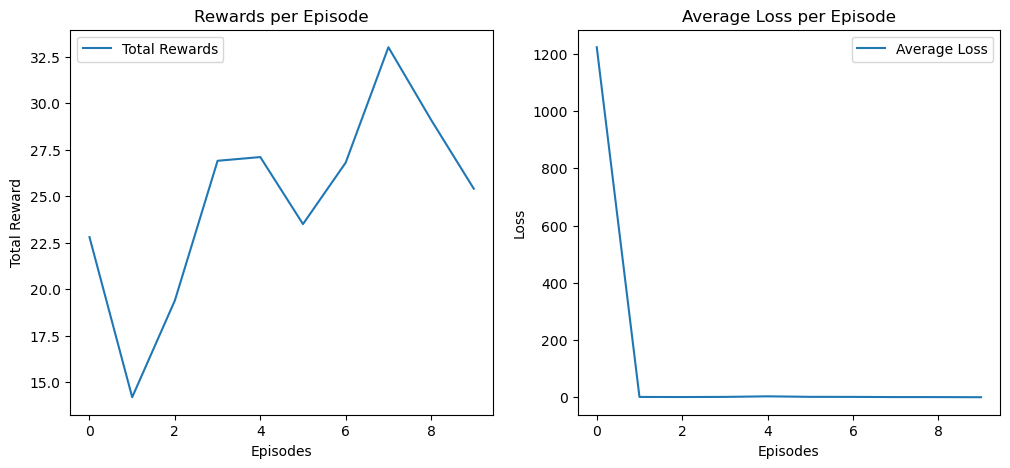

In [6]:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(total_rewards, label='Total Rewards')
        plt.title('Rewards per Episode')
        plt.xlabel('Episodes')
        plt.ylabel('Total Reward')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(average_losses, label='Average Loss')
        plt.title('Average Loss per Episode')
        plt.xlabel('Episodes')
        plt.ylabel('Loss')
        plt.legend()

In [9]:
# Set exploration rate to zero
agent.epsilon = 0.0

# Reset the environment
state = env.reset()
done = False

while not done:
    # Render the environment
    env.render()

    # Reshape state for the agent
    state = np.reshape(state, [1, state_size])

    # Choose action based on the trained policy
    action = agent.act(state)

    # Take the action and observe the new state and reward
    next_state, reward, done, _ = env.step(action)

    # Move to the next state
    state = next_state

    # You can add a small pause here if the game runs too fast
    # time.sleep(0.1)

# Close the rendering window when done
env.close()

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 25ms/step


KeyboardInterrupt: 

In [11]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [30]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
# Set up the video recorder
video_path = "./gameplay_video.mp4"
recorder = VideoRecorder(env, video_path)

state = env.reset()
done = False

# Start recording
recorder.capture_frame()

while not done:
    state = np.reshape(state, [1, agent.state_size])
    action = agent.act(state)  # Replace with your agent's action
    state, reward, done, _ = env.step(action)
    recorder.capture_frame()

recorder.close()
env.close()

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/dense_3/MatMul defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Kevin\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Kevin\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Kevin\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code

  File "C:\Users\Kevin\AppData\Local\Temp\ipykernel_19188\2933984054.py", line 10, in <module>

  File "C:\Users\Kevin\AppData\Local\Temp\ipykernel_19188\402889895.py", line 37, in act

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2631, in predict

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2416, in predict_function

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2401, in step_function

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2389, in run_step

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2357, in predict_step

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 589, in __call__

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\Kevin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py", line 241, in call

In[0] ndims must be >= 2: 1
	 [[{{node sequential_1/dense_3/MatMul}}]] [Op:__inference_predict_function_3611248]

In [25]:
from IPython.display import Video
Video(video_path)

ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')

In [38]:
import gym
import numpy as np
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# Initialize your custom environment and DQN agent
env = BallSortCraneEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Set up the video recorder
video_path = 'video_agent_gameplay.mp4'
video_recorder = VideoRecorder(env, path=video_path)

state = env.reset()
state = np.reshape(state, [1, state_size])
MAX_STEPS = 50  # Set the number of steps

for step in range(MAX_STEPS):
    action = agent.act(state)  # Select action based on trained agent
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    state = next_state

    video_recorder.capture_frame()  # Capture the frame

    if done:
        break

video_recorder.close()
env.close()


In [33]:
!pip install ffmpeg
!pip install imageio-ffmpeg

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6089 sha256=51328cd6df70f9e5e254a29f8bd5706b5ee4a420dad5378423a70bfa92dd1457
  Stored in directory: c:\users\kevin\appdata\local\pip\cache\wheels\56\30\c5\576bdd729f3bc062d62a551be7fefd6ed2f761901568171e4e
Successfully built ffmpeg
  Obtaining dependency information for imageio-ffmpeg from https://files.pythonhosted.org/packages/c6/01/716106099e48c4f419876d5814679a94dd7d6f441217c97c1b608123c6bb/imageio_ffmpeg-0.4.9-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/22.6 MB ? eta -:--:--
    --------------------------------------- 0.5/22.6 MB 10.5 MB/s eta 0:00:03
   ---- ----------------------------------- 2.6/22.6 MB 28.0 MB/s eta 0:00:01
   ---------- ----------------------------- 6.2/22.6 MB 43.9 MB/s eta 0:00:01
   ----------------- ---------------------- 10.1/22.6 MB 53.7 MB/s eta 0:

In [40]:
agent.model.save('./my_model')

INFO:tensorflow:Assets written to: ./my_model\assets


INFO:tensorflow:Assets written to: ./my_model\assets
